# Semantic Segmentation Lab

Jun Zhu
----

In this notebook, I built two segmentation networks to track VIP in an image. I used the data set for one of the projects at RoboND, Udacity. However, I have implemented different models. One is the original [SegNet](https://arxiv.org/pdf/1511.00561.pdf) and the other has a similar structure but all the convolutional layers are replaced by depthwise separable convolutional layers. Due to the technical constraint, **I have not combined the pooling indices in the encoder to the decoder!!!** Moreover, I used the default upsampling implemented in Keras which simply repeats the values in the lower layer and differs from bilinear upsampling.

In [1]:
import os
import glob
import sys
import cv2
import random
import pickle

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Data Visualization<a id='data_vis'></a>

In [2]:
def show_images(image_files, mask_files, infer_files=None, n_col=4, new_size=None):
    """Visualze the image and mask"""
    if infer_files is None:
        n_row = 2
    else:
        n_row = 3
        
    fig, ax = plt.subplots(n_row, n_col, figsize=(n_col*3.5, n_row*3.5))
    img_ax = ax[0, :]
    msk_ax = ax[1, :]
    if infer_files is not None:
        infer_ax = ax[2, :]
    for i in range(n_col):
        # Ensure we have all the classes in the image
        count = 0
        while True:
            count += 1                
            idx = random.choice(range(len(image_files)))
            if count > 100 or np.sum(np.sum(cv2.imread(mask_files[idx]), axis=0), axis=0).all() > 0:
                break
                
        img = cv2.imread(image_files[idx])[..., ::-1]
        msk = cv2.imread(mask_files[idx])[..., ::-1]
        if infer_files is not None:
            infer = cv2.imread(infer_files[idx])[..., ::-1]
        
        if new_size is not None:
            img = cv2.resize(img, new_size)
            msk = cv2.resize(msk, new_size)
            if infer_files is not None:
                infer = cv2.resize(infer, new_size)
        
        ax[0, i].imshow(img)
        ax[0, i].set_title(os.path.basename(image_files[idx]))
        ax[1, i].imshow(msk)
        ax[1, i].set_title(os.path.basename(mask_files[idx]))
        if infer_files is not None:
            ax[2, i].imshow(infer)
            ax[2, i].set_title(os.path.basename(infer_files[idx]))      

### Visualize the training data.

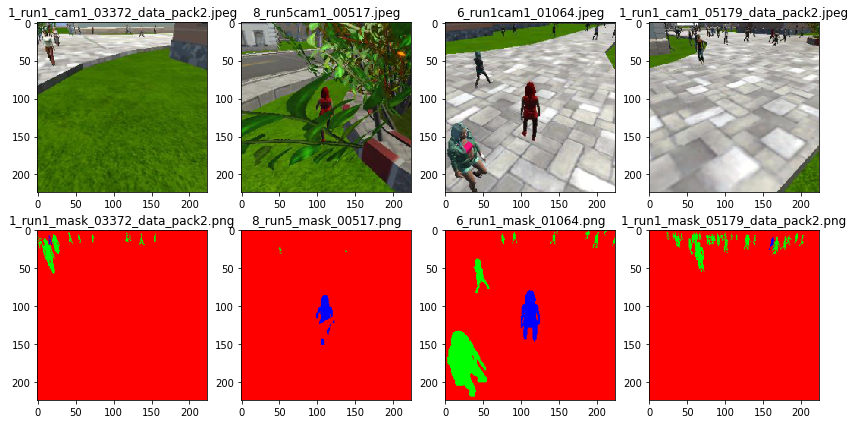

In [3]:
from parameters import train_data_folder
train_images = sorted(glob.glob(os.path.join(train_data_folder, 'images', '*.jpeg')))
train_masks = sorted(glob.glob(os.path.join(train_data_folder, 'masks', '*.png')))

show_images(train_images, train_masks, new_size=(224, 224))

### Visualize the validation data.

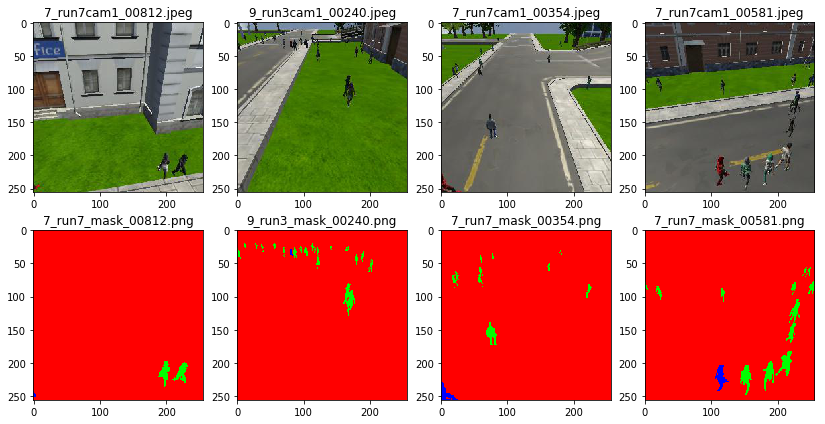

In [4]:
from parameters import vali_data_folder
vali_images = sorted(glob.glob(os.path.join(vali_data_folder, 'images', '*.jpeg')))
vali_masks = sorted(glob.glob(os.path.join(vali_data_folder, 'masks', '*.png')))

show_images(vali_images, vali_masks)

## Inferencee
The second row shows the ground truth masks and the third row is the inferred masks.

In [5]:
def plot_loss_history(filename):
    """"""
    with open(filename, "rb") as fp:
        loss_history = pickle.load(fp)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(loss_history['loss'])
    ax[1].plot(loss_history['val_loss'])
    for ax_ in ax:
        ax_.set_xlabel("epochs", fontsize=18)
        ax_.set_ylabel("loss", fontsize=18)
        ax_.tick_params(labelsize=16)
    ax[0].set_title("Train", fontsize=18)
    ax[1].set_title("Validation", fontsize=18)
    plt.tight_layout()
    plt.show()
    
    
def print_model(filename):
    """"""
    with open(filename, "r") as fp:
        for line in fp:
            print(line)

### Depthwise segnet

In this case, using very deep network (e.g. the VGG-SegNet structure) yielded very poor result. The reason might be that it is difficult to train the network end-to-end if it is too big.

In [6]:
print_model("models/depthwise_segnet_model.txt")

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_1 (InputLayer)         (None, 256, 256, 3)       0         

_________________________________________________________________

lambda_1 (Lambda)            (None, 160, 160, 3)       0         

_________________________________________________________________

separable_conv2d_1 (Separabl (None, 160, 160, 64)      283       

_________________________________________________________________

batch_normalization_1 (Batch (None, 160, 160, 64)      256       

_________________________________________________________________

activation_1 (Activation)    (None, 160, 160, 64)      0         

_________________________________________________________________

max_pooling2d_1 (MaxPooling2 (None, 80, 80, 64)        0         

_________________________________________________________________

separable_conv2d_2 (Separabl (None, 80, 80, 128)       8896  

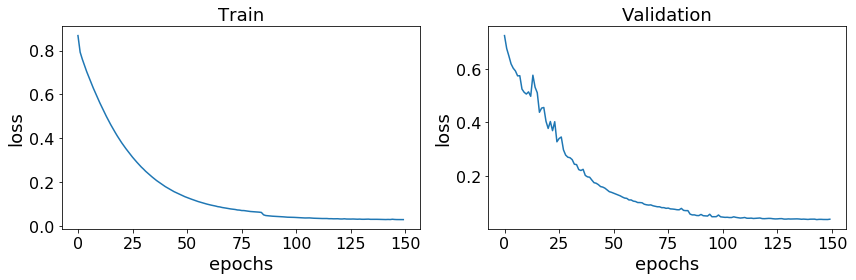

In [7]:
plot_loss_history("models/depthwise_segnet_loss.pkl")

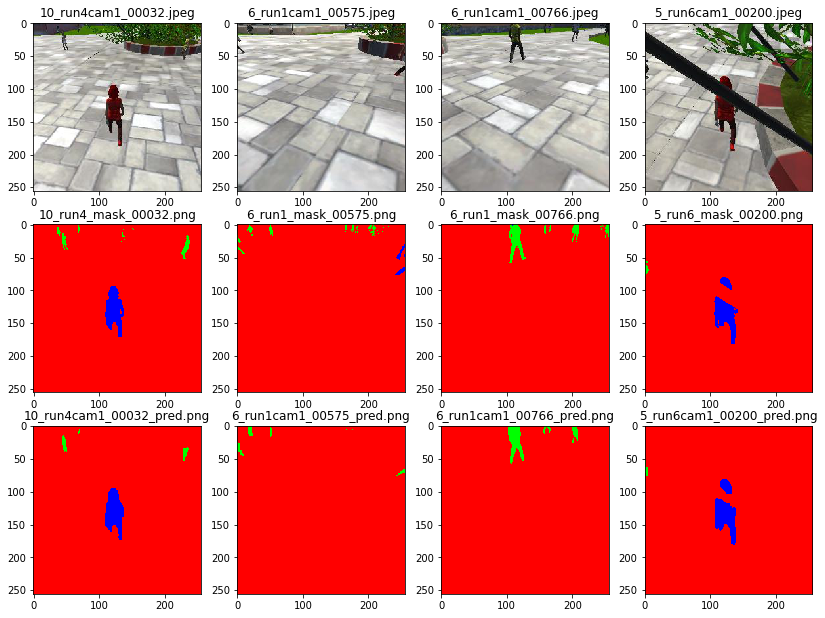

In [8]:
from parameters import test_data_folder
test_images = sorted(glob.glob(os.path.join(test_data_folder, 'images', '*.jpeg')))
test_masks = sorted(glob.glob(os.path.join(test_data_folder, 'masks', '*.png')))

output_folder = "depthwise_segnet_inference"
pred_images = sorted(glob.glob(os.path.join(output_folder, "*.png")))

show_images(test_images, test_masks, pred_images)

###  Segnet

In [9]:
print_model("models/segnet_model.txt")

_________________________________________________________________

Layer (type)                 Output Shape              Param #   


input_1 (InputLayer)         (None, 256, 256, 3)       0         

_________________________________________________________________

lambda_1 (Lambda)            (None, 160, 160, 3)       0         

_________________________________________________________________

conv2d_1 (Conv2D)            (None, 160, 160, 64)      1792      

_________________________________________________________________

batch_normalization_1 (Batch (None, 160, 160, 64)      256       

_________________________________________________________________

activation_1 (Activation)    (None, 160, 160, 64)      0         

_________________________________________________________________

max_pooling2d_1 (MaxPooling2 (None, 80, 80, 64)        0         

_________________________________________________________________

conv2d_2 (Conv2D)            (None, 80, 80, 128)       73856 

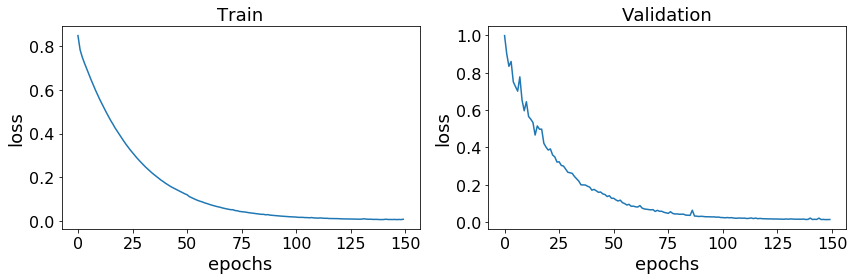

In [10]:
# The total number of epochs is also 150, but the file only stores 30 points.
plot_loss_history("models/segnet_loss.pkl")

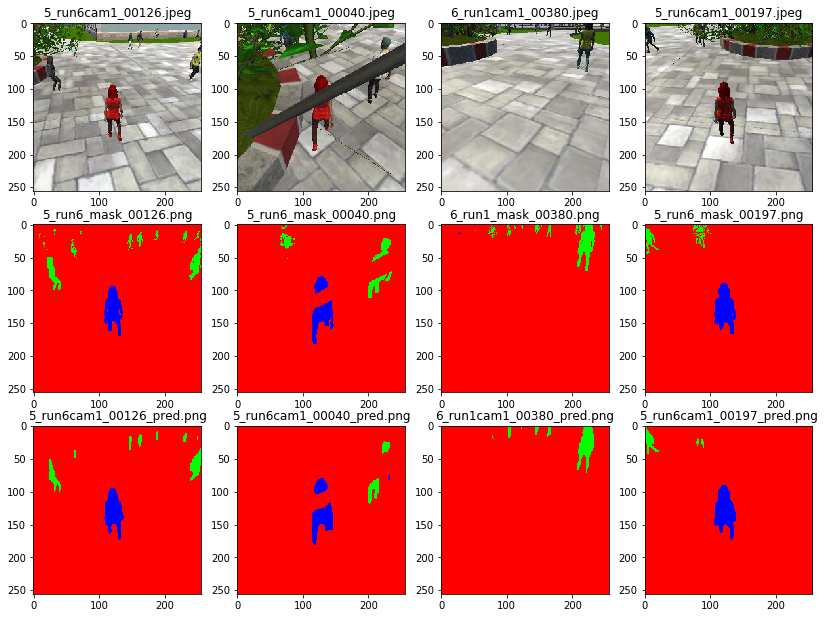

In [11]:
from parameters import test_data_folder
test_images = sorted(glob.glob(os.path.join(test_data_folder, 'images', '*.jpeg')))
test_masks = sorted(glob.glob(os.path.join(test_data_folder, 'masks', '*.png')))

output_folder = "segnet_inference"
pred_images = sorted(glob.glob(os.path.join(output_folder, "*.png")))

show_images(test_images, test_masks, pred_images)

## Summary

Using depthwise convolutional layers in a SegNet significantly reduces the memory footprint. However, normal SegNet structure is slightly better at inferencing fine structures.